In [1]:
import numpy as np
import pandas as pd

# -----------------------------
# Metric functions (as given)
# -----------------------------
def nse(obs: np.ndarray, sim: np.ndarray) -> float:
    m = np.nanmean(obs)
    denom = np.nansum((obs - m) ** 2)
    if denom == 0 or np.isnan(denom):
        return np.nan
    return 1.0 - np.nansum((sim - obs) ** 2) / denom

def nnse(obs, sim):
    v = nse(obs, sim)
    return np.nan if np.isnan(v) else 1.0 / (2.0 - v)

def mse(obs, sim):
    return np.nanmean((sim - obs) ** 2)

def mae(obs, sim):
    return np.nanmean(np.abs(sim - obs))

def kge(obs, sim) -> float:
    obs_m, sim_m = np.nanmean(obs), np.nanmean(sim)
    obs_s, sim_s = np.nanstd(obs, ddof=0), np.nanstd(sim, ddof=0)
    valid = np.isfinite(obs) & np.isfinite(sim)
    if valid.sum() < 2 or obs_s == 0 or np.isnan(obs_m) or np.isnan(sim_m):
        return np.nan
    r = np.corrcoef(obs[valid], sim[valid])[0, 1]
    beta = np.nan if obs_m == 0 else sim_m / obs_m
    gamma = np.nan if (sim_m == 0 or obs_m == 0 or obs_s == 0) else (sim_s / sim_m) / (obs_s / obs_m)
    if np.isnan(r) or np.isnan(beta) or np.isnan(gamma):
        return np.nan
    return 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)

def mape(obs, sim):
    valid = np.isfinite(obs) & np.isfinite(sim) & (obs != 0)
    return np.nanmean(np.abs((sim[valid] - obs[valid]) / obs[valid])) * 100

def rnse(obs, sim):
    # normalized NSE (divides by sum of obs^2)
    denom = np.nansum(obs ** 2)
    if denom == 0 or np.isnan(denom):
        return np.nan
    return 1.0 - np.nansum((sim - obs) ** 2) / denom

def rmae(obs, sim):
    valid = np.isfinite(obs) & np.isfinite(sim) & (obs != 0)
    return np.nanmean(np.abs((sim[valid] - obs[valid]) / obs[valid])) * 100  # now %

def nrmse(obs, sim):
    rmse = np.sqrt(np.nanmean((sim - obs) ** 2))
    obs_range = np.nanmax(obs) - np.nanmin(obs)
    return (rmse / obs_range) * 100 if obs_range != 0 else np.nan  # now %



METRIC_FUNS = {
    "NSE": nse,
    "NNSE": nnse,
    "MSE": mse,
    "MAE": mae,
    "KGE": kge,
    "rNSE": rnse,
    "rMAE": rmae,
    "MAPE (%)": mape,
    "NRMSE": nrmse
}


# -----------------------------
# Configuration
# -----------------------------
file_path = "for_scatterplot.xlsx"

OBS_COLUMN = "Qm (Thebes)"  

SIM_COLUMN = "Qnew"

def compute_metrics(obs: pd.Series, sim: pd.Series) -> dict:
    data = pd.concat([obs, sim], axis=1).dropna()
    if data.empty:
        return {k: np.nan for k in METRIC_FUNS} | {"N": 0}

    o = data.iloc[:, 0].to_numpy()
    s = data.iloc[:, 1].to_numpy()
    metrics = {name: func(o, s) for name, func in METRIC_FUNS.items()}
    metrics["N"] = len(data)
    return metrics

# --------------------------------------------------
# Process all sheets
# --------------------------------------------------
xls = pd.ExcelFile(file_path)
results = []

for sheet in xls.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    if OBS_COLUMN not in df.columns or SIM_COLUMN not in df.columns:
        print(f"Skipping '{sheet}' (columns missing)")
        continue

    metrics = compute_metrics(df[OBS_COLUMN], df[SIM_COLUMN])
    results.append({"Sheet": sheet} | metrics)

# --------------------------------------------------
# Create summary table
# --------------------------------------------------
summary = pd.DataFrame(results)
pd.set_option("display.max_columns", None)
print(summary)

# Optionally save to Excel
output_file = "model_metrics_summary.xlsx"
summary.to_excel(output_file, index=False)
print(f"\nSaved metrics to: {output_file}")

      Sheet       NSE      NNSE           MSE          MAE       KGE  \
0  Method_1  0.999746  0.999746  7.455896e+06  1825.262622  0.993740   
1  Method_2  0.999084  0.999085  2.684756e+07  4562.601232  0.981294   
2  Method_3  0.999800  0.999800  5.869410e+06  1875.320824  0.993476   

       rNSE      rMAE  MAPE (%)     NRMSE       N  
0  0.999928  0.694202  0.694202  0.312742  106822  
1  0.999740  1.975157  1.975157  0.593456  106822  
2  0.999943  0.792286  0.792286  0.277481  106822  

Saved metrics to: model_metrics_summary.xlsx


C:\Users\smncd\AppData\Local\Temp\ipykernel_24944\3190496792.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axQ.set_xticklabels([f"{int(t):,}" for t in axQ.get_xticks()])


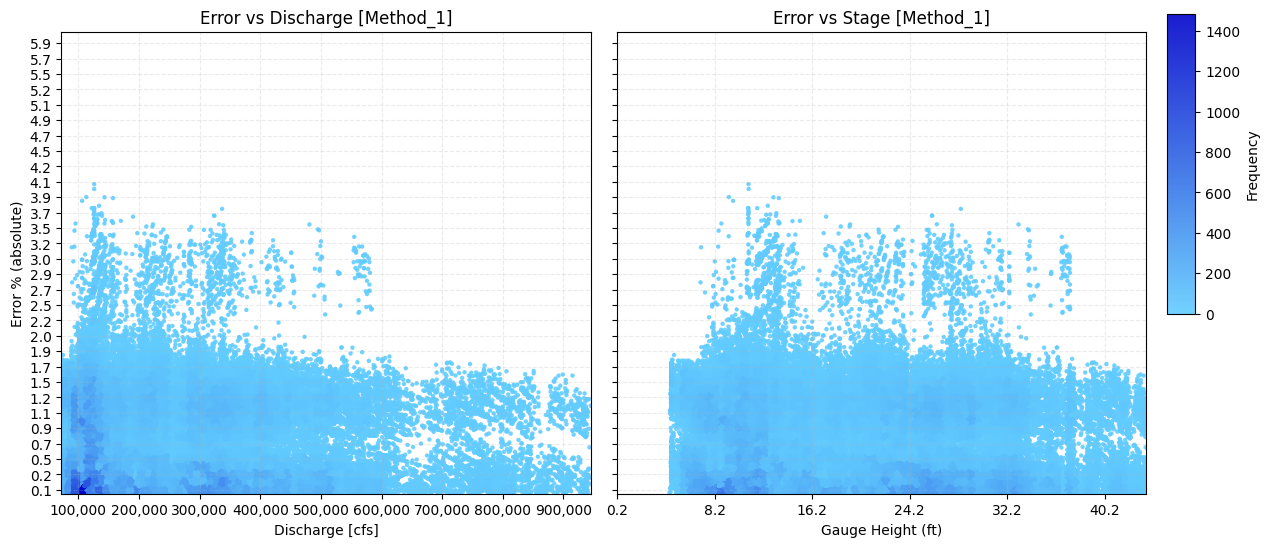

C:\Users\smncd\AppData\Local\Temp\ipykernel_24944\3190496792.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axQ.set_xticklabels([f"{int(t):,}" for t in axQ.get_xticks()])


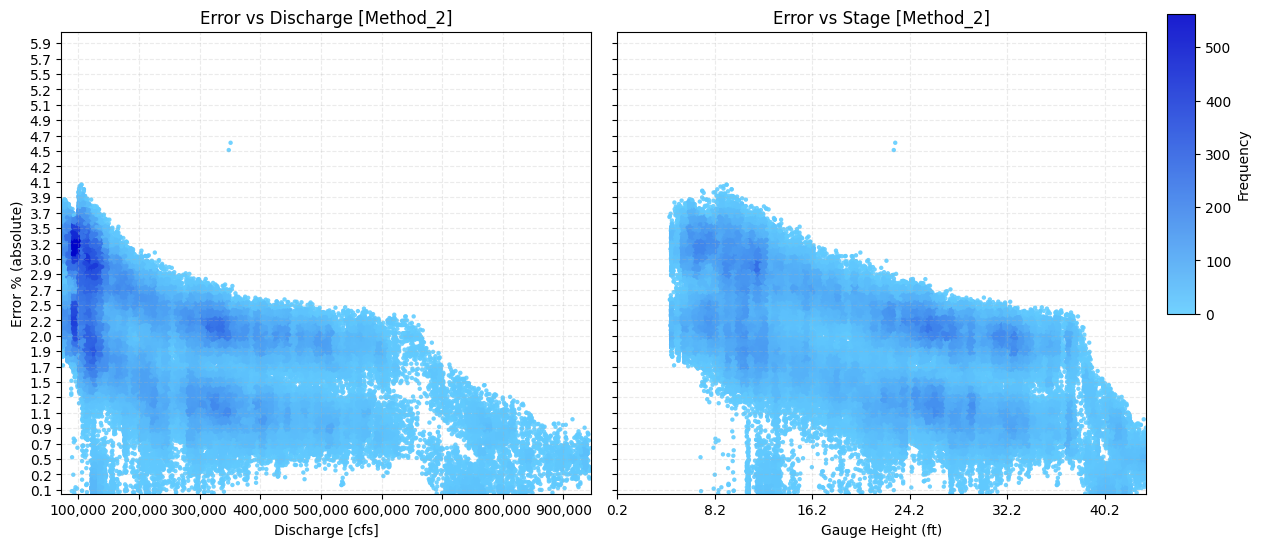

C:\Users\smncd\AppData\Local\Temp\ipykernel_24944\3190496792.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axQ.set_xticklabels([f"{int(t):,}" for t in axQ.get_xticks()])


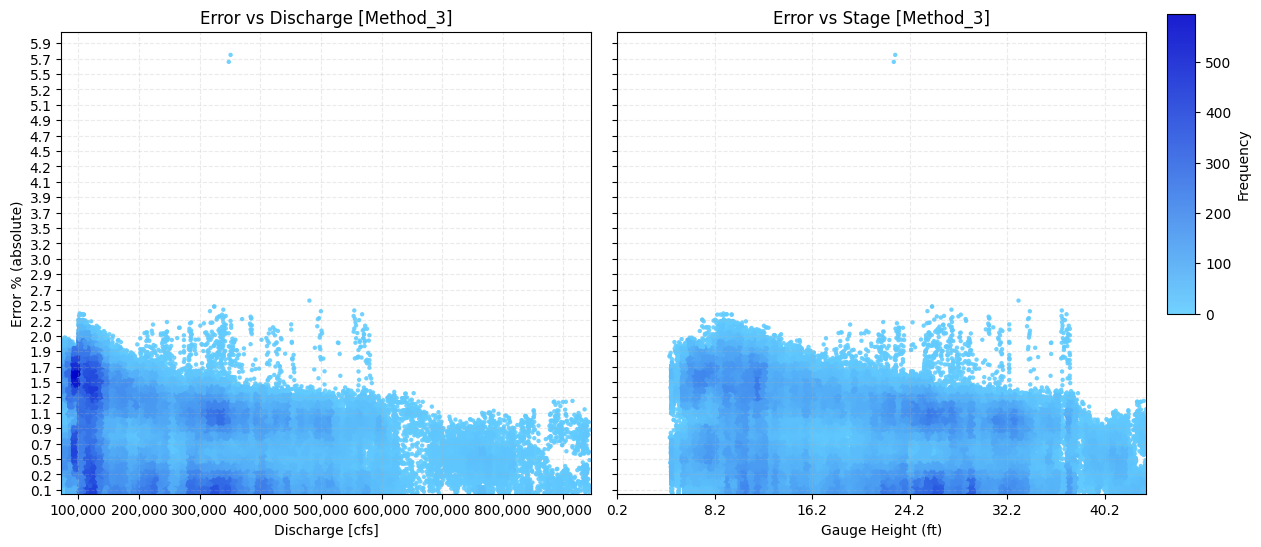

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, ScalarFormatter, FuncFormatter


file_path = "for_scatterplot.xlsx"
SHEETS = ["Method_1", "Method_2", "Method_3"]

# ----- Colormap: Blue_hue (#62CDFF -> #0003ca) -----
Blue_hue = LinearSegmentedColormap.from_list("Blue_hue", ["#62CDFF", "#0003ca"])

def _midpoints(edges):
    return (edges[:-1] + edges[1:]) / 2.0

def _bin_counts_for_xy(x, y, x_edges, y_edges):
    """Return filtered points, counts matrix, and per-point bin counts for coloring."""
    ix = np.digitize(x, x_edges) - 1
    iy = np.digitize(y, y_edges) - 1
    mask = (ix >= 0) & (ix < len(x_edges) - 1) & (iy >= 0) & (iy < len(y_edges) - 1)
    ix, iy = ix[mask], iy[mask]
    x, y = x[mask], y[mask]

    counts = np.zeros((len(x_edges) - 1, len(y_edges) - 1), dtype=int)
    np.add.at(counts, (ix, iy), 1)
    c = counts[ix, iy]
    return x, y, counts, c

def _tick_midpoints(edges, step_value, bin_step_value):
    """
    Choose midpoint ticks. 
    - edges: bin edges
    - step_value: desired tick spacing in axis units (e.g., 0.5 for y, 200_000 for discharge x, 8.0 for GH)
    - bin_step_value: bin width for this axis (e.g., y_step, q_step, gh_step)
    """
    mids = _midpoints(edges)
    # Convert desired tick spacing to "every N bins"
    N = max(1, int(round(step_value / bin_step_value)))
    return mids[::N]

def scatter_two_panels_same_scale(
    df, sheet_name,
    # ---- bin definitions ----
    q_step=100_000, q_max=1_000_000,          # Discharge bins (x)
    gh_step=4.0, gh_max=45.0,                 # Stage bins (x)
    y_step=0.5, y_max=6.0,                    # Error bins (y)
    # ---- which midpoints to show as ticks (axis units) ----
    q_tick_step=200_000,                      # show a tick every 200k discharge
    gh_tick_step=8.0,                         # show a tick every 8.0 ft (or m)
    y_tick_step=0.5,                          # show a tick every 0.5% error
):
    # Build edges
    x_edges_Q  = np.arange(0, q_max + q_step, q_step)
    x_edges_GH = np.arange(0.0, gh_max + gh_step, gh_step)
    y_edges    = np.arange(0.0, y_max + y_step, y_step)

    # Clip and prep data: Discharge vs Error
    data_Q = df[["Qm (Thebes)", "Error % (absolute)"]].dropna().copy()
    data_Q["Qm (Thebes)"] = data_Q["Qm (Thebes)"].clip(x_edges_Q[0], x_edges_Q[-1])
    data_Q["Error % (absolute)"] = data_Q["Error % (absolute)"].clip(y_edges[0], y_edges[-1])
    xQ = data_Q["Qm (Thebes)"].to_numpy()
    yQ = data_Q["Error % (absolute)"].to_numpy()
    xQ, yQ, counts_Q, cQ = _bin_counts_for_xy(xQ, yQ, x_edges_Q, y_edges)

    # Clip and prep data: Stage vs Error
    data_GH = df[["Gauge Height (GH)", "Error % (absolute)"]].dropna().copy()
    data_GH["Gauge Height (GH)"] = data_GH["Gauge Height (GH)"].clip(x_edges_GH[0], x_edges_GH[-1])
    data_GH["Error % (absolute)"] = data_GH["Error % (absolute)"].clip(y_edges[0], y_edges[-1])
    xH = data_GH["Gauge Height (GH)"].to_numpy()
    yH = data_GH["Error % (absolute)"].to_numpy()
    xH, yH, counts_H, cH = _bin_counts_for_xy(xH, yH, x_edges_GH, y_edges)

    # Shared color scaling across both panels
    vmax = int(max(cQ.max() if cQ.size else 0, cH.max() if cH.size else 0))
    vmin = 0
    norm = Normalize(vmin=vmin, vmax=vmax if vmax > 0 else 1)

    # Figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.subplots_adjust(wspace=0.05)
    axQ, axH = axes

    # --- Left: Discharge vs Error ---
    s1 = axQ.scatter(xQ, yQ, c=cQ, cmap=Blue_hue, norm=norm, s=10, alpha=0.9, edgecolors="none")

    axH.grid(True, axis="both", which="major", linestyle=":", linewidth=0.8, alpha=0.6)
    axQ.set_xlim(left=data_Q["Qm (Thebes)"].min(), right=data_Q["Qm (Thebes)"].max())
    axQ.set_ylim(y_edges[0], y_edges[-1])
    axQ.set_xlabel("Discharge [cfs]")
    axQ.set_ylabel("Error % (absolute)")
    axQ.set_title(f"Error vs Discharge [{sheet_name}]")
    axQ.grid(True, linestyle="--", alpha=0.25)

    # Scientific notation for Discharge (Q)
    axQ.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axQ.ticklabel_format(style='sci', axis='x', scilimits=(5, 5))


    axQ.set_yticks(_tick_midpoints(y_edges, y_tick_step, y_step))

    # Nicely formatted tick labels (integers for Q, one decimal for y)
    axQ.set_xticklabels([f"{int(t):,}" for t in axQ.get_xticks()])
    axQ.set_yticklabels([f"{t:.1f}" for t in axQ.get_yticks()])

    # --- Right: Stage vs Error ---
    s2 = axH.scatter(xH, yH, c=cH, cmap=Blue_hue, norm=norm, s=10, alpha=0.9, edgecolors="none")
    axH.grid(True, axis="both", which="major", linestyle=":", linewidth=0.8, alpha=0.6)
    axH.set_xlim(data_GH["Gauge Height (GH)"].min(), data_GH["Gauge Height (GH)"].max())
    axH.set_ylim(y_edges[0], y_edges[-1])
    axH.set_xlabel("Gauge Height (ft)")
    axH.set_ylabel("")
    axH.set_title(f"Error vs Stage [{sheet_name}]")
    axH.grid(True, linestyle="--", alpha=0.25)

    # Midpoint ticks
    xticks_H = _tick_midpoints(x_edges_GH, gh_tick_step, gh_step)
    axH.set_xticks(xticks_H)
    axH.xaxis.set_major_locator(FixedLocator(xticks_H))
    axH.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}"))
    axH.set_yticks(_tick_midpoints(y_edges, y_tick_step, y_step))

    # Labels for GH as simple decimals, y as one decimal
    axH.set_xticklabels([f"{t:.1f}" for t in axH.get_xticks()])
    axH.set_yticklabels([f"{t:.1f}" for t in axH.get_yticks()])

    cbar_ax = fig.add_axes([0.915, 0.41, 0.02, 0.5])  # (left, bottom, width, height)
    cbar = fig.colorbar(s1, cax=cbar_ax)
    cbar.set_label("Frequency")
    
    plt.show()

# ---- Run for each sheet with your preferred tick spacing ----
for sheet in SHEETS:
    df = pd.read_excel(file_path, sheet_name=sheet)
    scatter_two_panels_same_scale(
        df, sheet,
        # bins (leave as-is unless you want different bin sizes)
        q_step=10_000, q_max=1_000_000,
        gh_step=0.5, gh_max=45.0,
        y_step=0.1, y_max=6.0,
        # tick spacing (choose what to show)
        q_tick_step=200_000,  # show every 200k midpoint on discharge x
        gh_tick_step=8.0,     # show every 8.0 midpoint on GH x
        y_tick_step=0.2       # show every 0.5 midpoint on y
    )


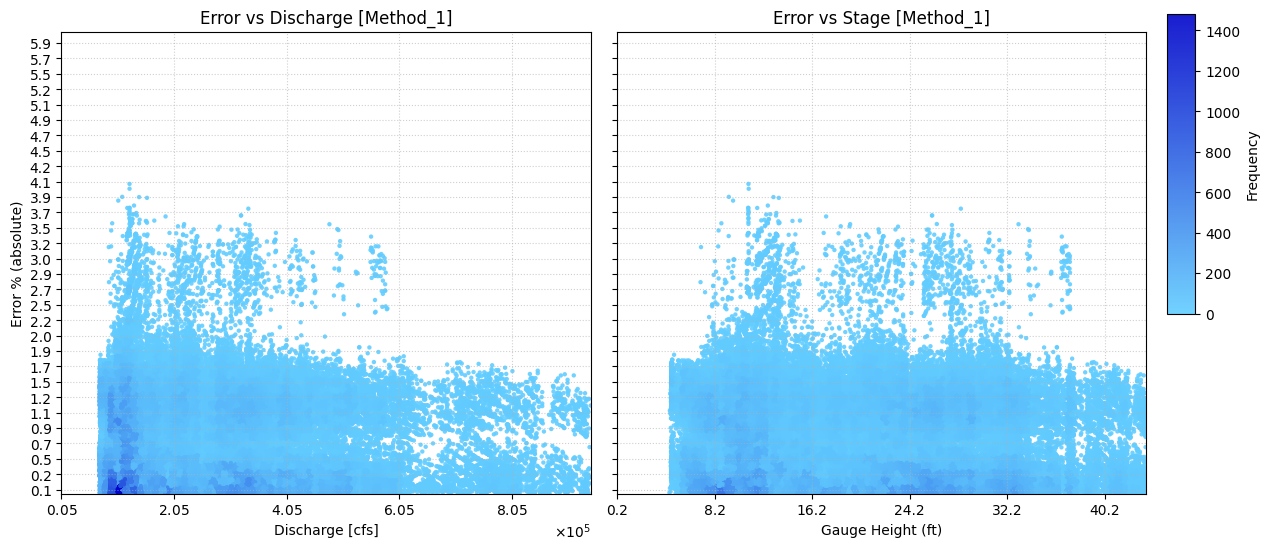

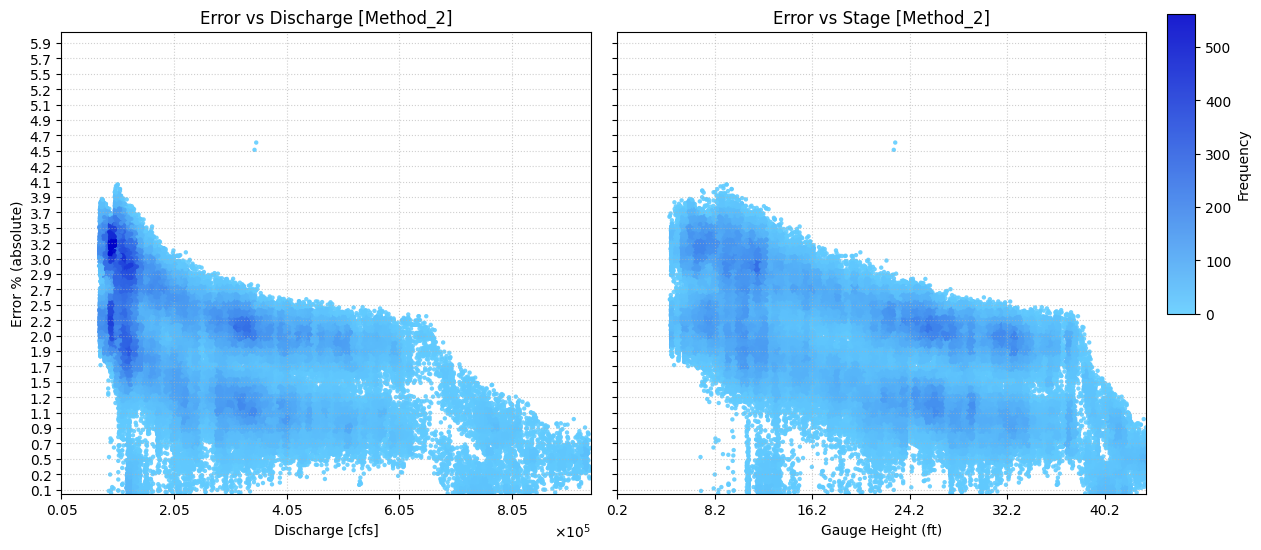

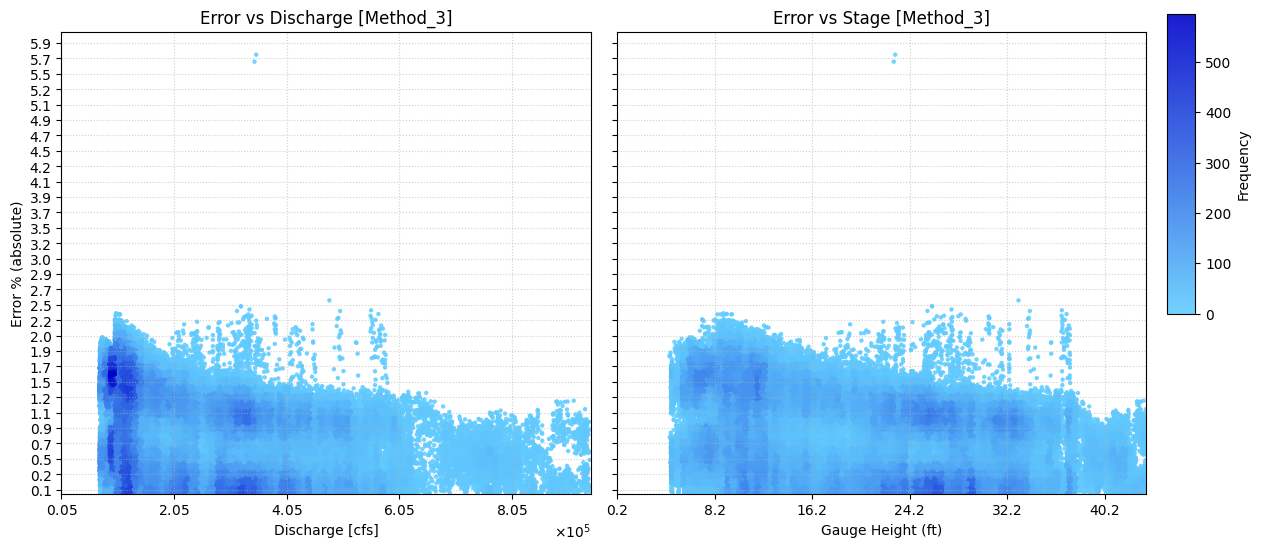

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.ticker import FixedLocator, ScalarFormatter, FuncFormatter

# ======= CONFIG =======
file_path = "for_scatterplot.xlsx"
SHEETS = ["Method_1", "Method_2", "Method_3"]

# Custom colormap: light to deep blue
Blue_hue = LinearSegmentedColormap.from_list("Blue_hue", ["#62CDFF", "#0003ca"])


# ======= HELPER FUNCTIONS =======
def _midpoints(edges):
    return (edges[:-1] + edges[1:]) / 2.0


def _bin_counts_for_xy(x, y, x_edges, y_edges):
    """Compute per-point frequency counts for color mapping."""
    ix = np.digitize(x, x_edges) - 1
    iy = np.digitize(y, y_edges) - 1
    mask = (ix >= 0) & (ix < len(x_edges) - 1) & (iy >= 0) & (iy < len(y_edges) - 1)
    ix, iy = ix[mask], iy[mask]
    x, y = x[mask], y[mask]

    counts = np.zeros((len(x_edges) - 1, len(y_edges) - 1), dtype=int)
    np.add.at(counts, (ix, iy), 1)
    c = counts[ix, iy]
    return x, y, counts, c


def _tick_midpoints(edges, tick_spacing, bin_width):
    """Select tick midpoints at the requested interval."""
    mids = _midpoints(edges)
    N = max(1, int(round(tick_spacing / bin_width)))
    return mids[::N]


# ======= MAIN PLOT FUNCTION =======
def scatter_two_panels_same_scale(
    df, sheet_name,
    q_step=10_000, q_max=1_000_000,
    gh_step=0.5, gh_max=45.0,
    y_step=0.1, y_max=6.0,
    q_tick_step=200_000,
    gh_tick_step=8.0,
    y_tick_step=0.2,
):
    # Bin edges
    x_edges_Q = np.arange(0, q_max + q_step, q_step)
    x_edges_GH = np.arange(0, gh_max + gh_step, gh_step)
    y_edges = np.arange(0, y_max + y_step, y_step)

    # --- Discharge vs Error
    data_Q = df[["Qm (Thebes)", "Error % (absolute)"]].dropna().copy()
    data_Q["Qm (Thebes)"] = data_Q["Qm (Thebes)"].clip(x_edges_Q[0], x_edges_Q[-1])
    data_Q["Error % (absolute)"] = data_Q["Error % (absolute)"].clip(y_edges[0], y_edges[-1])
    xQ, yQ = data_Q["Qm (Thebes)"].to_numpy(), data_Q["Error % (absolute)"].to_numpy()
    xQ, yQ, counts_Q, cQ = _bin_counts_for_xy(xQ, yQ, x_edges_Q, y_edges)

    # --- Stage vs Error
    data_GH = df[["Gauge Height (GH)", "Error % (absolute)"]].dropna().copy()
    data_GH["Gauge Height (GH)"] = data_GH["Gauge Height (GH)"].clip(x_edges_GH[0], x_edges_GH[-1])
    data_GH["Error % (absolute)"] = data_GH["Error % (absolute)"].clip(y_edges[0], y_edges[-1])
    xH, yH = data_GH["Gauge Height (GH)"].to_numpy(), data_GH["Error % (absolute)"].to_numpy()
    xH, yH, counts_H, cH = _bin_counts_for_xy(xH, yH, x_edges_GH, y_edges)

    # Shared color scaling
    vmax = int(max(cQ.max() if cQ.size else 0, cH.max() if cH.size else 0))
    norm = Normalize(vmin=0, vmax=vmax if vmax > 0 else 1)

    # Create figure
    fig, (axQ, axH) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.subplots_adjust(wspace=0.05)

    # ===== Left panel: Discharge =====
    s1 = axQ.scatter(xQ, yQ, c=cQ, cmap=Blue_hue, norm=norm, s=10, alpha=0.9, edgecolors="none")
    axQ.set_xlim(data_Q["Qm (Thebes)"].min(), data_Q["Qm (Thebes)"].max())
    axQ.set_ylim(y_edges[0], y_edges[-1])
    axQ.set_xlabel("Discharge [cfs]")
    axQ.set_ylabel("Error % (absolute)")
    axQ.set_title(f"Error vs Discharge [{sheet_name}]")
    axQ.grid(True, linestyle=":", alpha=0.6)

    # --- X ticks (scientific notation)
    xticks_Q = _tick_midpoints(x_edges_Q, q_tick_step, q_step)
    axQ.set_xticks(xticks_Q)
    axQ.xaxis.set_major_locator(FixedLocator(xticks_Q))

    sf = ScalarFormatter(useMathText=True)
    sf.set_powerlimits((5, 5))
    axQ.xaxis.set_major_formatter(sf)
    axQ.get_xaxis().get_offset_text().set_fontsize(10)

    # --- Y ticks
    yticks = _tick_midpoints(y_edges, y_tick_step, y_step)
    axQ.set_yticks(yticks)
    axQ.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}"))

    # ===== Right panel: Stage =====
    s2 = axH.scatter(xH, yH, c=cH, cmap=Blue_hue, norm=norm, s=10, alpha=0.9, edgecolors="none")
    axH.set_xlim(data_GH["Gauge Height (GH)"].min(), data_GH["Gauge Height (GH)"].max())
    axH.set_xlabel("Gauge Height (ft)")
    axH.set_title(f"Error vs Stage [{sheet_name}]")
    axH.grid(True, linestyle=":", alpha=0.6)

    # --- X ticks for Gauge Height
    xticks_H = _tick_midpoints(x_edges_GH, gh_tick_step, gh_step)
    axH.set_xticks(xticks_H)
    axH.xaxis.set_major_locator(FixedLocator(xticks_H))
    axH.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v)}"))

    # --- Y ticks (same as left)
    axH.set_yticks(yticks)
    axH.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}"))

    # ===== Colorbar (top-right)
    cbar_ax = fig.add_axes([0.915, 0.41, 0.02, 0.5])  # [left, bottom, width, height]
    cbar = fig.colorbar(s1, cax=cbar_ax)
    cbar.set_label("Frequency")

    plt.show()


# ======= RUN FOR ALL SHEETS =======
for sheet in SHEETS:
    df = pd.read_excel(file_path, sheet_name=sheet)
    scatter_two_panels_same_scale(df, sheet)
